In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

"""Example sklearn pipeline workflow

1. Create a ColumnTranformer to preprocess data
2. Create a Pipeline to fit model
3. Fit pipeline using GridSearchCV
4. Save best model to file
5. Read saved model to predict on new data
"""


# Imports

In [2]:
import pickle

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report

import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline

<IPython.core.display.Javascript object>

In [4]:
# Import the data and check the head
full_df = pd.read_csv(
    "Data/woodbine_horses.csv", skipinitialspace=True, low_memory=False
)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 500)
full_df.head(3)

,track,card_id,race_date,breed,name,weight,age,sex,meds_and_equip,jockey,dollar_odds,program_number,post_position,claim_price,start_position,finish_position,finish_time,speed_rating,trainer,owner,win_payoff,place_payoff,show_payoff,weather,distance,race_type,track_conditions
0,WO,D,2014-10-24 00:00:00,TB,Shogun Rua,119,6,G,L,J I Alderson,1.50,3.0,3,6000,4.0,1.0,0.0,71.0,McKnight Norman,Bruno Schickedanz,5.0,3.3,3.1,Cloudy,600.0,Claiming,FT
1,WO,D,2014-11-22 00:00:00,TB,Josai's Angel,121,4,M,L,T Wong,58.15,4.0,4,9500,9.0,10.0,0.0,25.0,Pottins Judith R,"Shortstop Stable and Zahreddine, Ramez",0.0,0.0,0.0,Cloudy,500.0,Maiden Claiming,FT
2,WO,D,2014-11-23 00:00:00,TB,My Girl Madison,121,5,M,Lf,S Ryan,17.05,1.0,1,0,2.0,7.0,0.0,51.0,Fournier Mark,Bruno Schickedanz,0.0,0.0,0.0,Cloudy,600.0,Allowance,FT


<IPython.core.display.Javascript object>

# Choose Data

In [5]:
# This is a list of colums to drop from the analysis beacause they will not be useful
drop_cols = [
    "track",  # Same for every row
    "card_id",  # Same for every row
    "race_date",  # Provides little value to model
    "breed",  # Same for every row
    "name",  # There are almost 2000 different names with the max enteries per name = 12
    "program_number",  # Ambiguous catagorical information
    "finish_time",  # Same for every row
    "win_payoff",  # Provides little value to model
    "place_payoff",  # Provides little value to model
    "show_payoff",  # Provides little value to model
    "start_position",  # Info gained after race start is not useful for future predictions
    "dollar_odds",  # Man made odds metric, useful for prediction evaluation
]

<IPython.core.display.Javascript object>

In [6]:
df = full_df.drop(drop_cols, axis=1)

<IPython.core.display.Javascript object>

In [7]:
df.head(3)

,weight,age,sex,meds_and_equip,jockey,post_position,claim_price,finish_position,speed_rating,trainer,owner,weather,distance,race_type,track_conditions
0,119,6,G,L,J I Alderson,3,6000,1.0,71.0,McKnight Norman,Bruno Schickedanz,Cloudy,600.0,Claiming,FT
1,121,4,M,L,T Wong,4,9500,10.0,25.0,Pottins Judith R,"Shortstop Stable and Zahreddine, Ramez",Cloudy,500.0,Maiden Claiming,FT
2,121,5,M,Lf,S Ryan,1,0,7.0,51.0,Fournier Mark,Bruno Schickedanz,Cloudy,600.0,Allowance,FT


<IPython.core.display.Javascript object>

## Handle Null Values

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8113 entries, 0 to 8112
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   weight            8113 non-null   int64  
 1   age               8113 non-null   int64  
 2   sex               7522 non-null   object 
 3   meds_and_equip    7264 non-null   object 
 4   jockey            7522 non-null   object 
 5   post_position     8113 non-null   int64  
 6   claim_price       8113 non-null   int64  
 7   finish_position   8113 non-null   float64
 8   speed_rating      7522 non-null   float64
 9   trainer           7522 non-null   object 
 10  owner             7522 non-null   object 
 11  weather           8113 non-null   object 
 12  distance          8113 non-null   float64
 13  race_type         8113 non-null   object 
 14  track_conditions  8113 non-null   object 
dtypes: float64(3), int64(4), object(8)
memory usage: 950.9+ KB


<IPython.core.display.Javascript object>

In [9]:
# Remove 7% of the rows that have nulls in 5 colums
df = df[df["sex"].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7522 entries, 0 to 8112
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   weight            7522 non-null   int64  
 1   age               7522 non-null   int64  
 2   sex               7522 non-null   object 
 3   meds_and_equip    7264 non-null   object 
 4   jockey            7522 non-null   object 
 5   post_position     7522 non-null   int64  
 6   claim_price       7522 non-null   int64  
 7   finish_position   7522 non-null   float64
 8   speed_rating      7522 non-null   float64
 9   trainer           7522 non-null   object 
 10  owner             7522 non-null   object 
 11  weather           7522 non-null   object 
 12  distance          7522 non-null   float64
 13  race_type         7522 non-null   object 
 14  track_conditions  7522 non-null   object 
dtypes: float64(3), int64(4), object(8)
memory usage: 940.2+ KB


<IPython.core.display.Javascript object>

In [10]:
# Replace nulls in `meds_and_equip` with "NA" for now
df["meds_and_equip"].fillna("N", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7522 entries, 0 to 8112
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   weight            7522 non-null   int64  
 1   age               7522 non-null   int64  
 2   sex               7522 non-null   object 
 3   meds_and_equip    7522 non-null   object 
 4   jockey            7522 non-null   object 
 5   post_position     7522 non-null   int64  
 6   claim_price       7522 non-null   int64  
 7   finish_position   7522 non-null   float64
 8   speed_rating      7522 non-null   float64
 9   trainer           7522 non-null   object 
 10  owner             7522 non-null   object 
 11  weather           7522 non-null   object 
 12  distance          7522 non-null   float64
 13  race_type         7522 non-null   object 
 14  track_conditions  7522 non-null   object 
dtypes: float64(3), int64(4), object(8)
memory usage: 940.2+ KB


<IPython.core.display.Javascript object>

# Feature Engineering

In [11]:
df["meds_and_equip"].value_counts()

L       3050
Lb      3046
Lbf      409
Lf       386
N        258
b        246
Lv        27
Ly        15
bf        14
f         13
y         12
Lfy        8
Lr         7
Lvf        7
Lby        7
by         5
v          4
Lbr        3
Lyf        1
bfy        1
Lbfy       1
Lvr        1
Lbfr       1
Name: meds_and_equip, dtype: int64

<IPython.core.display.Javascript object>

In [12]:
# Create catagorical columns to encode `meds_and_equip` into
df["L"] = 0
df["b"] = 0
df["f"] = 0
df["r"] = 0
df["y"] = 0
df["v"] = 0
df["N"] = 0

<IPython.core.display.Javascript object>

In [13]:
meds_and_equip_unique = df["meds_and_equip"].unique()
meds_and_equip_unique

array(['L', 'Lf', 'Lb', 'Lr', 'Lbf', 'N', 'b', 'Ly', 'Lv', 'y', 'Lvf',
       'Lbr', 'f', 'by', 'Lyf', 'Lby', 'bf', 'Lvr', 'Lfy', 'Lbfy', 'v',
       'bfy', 'Lbfr'], dtype=object)

<IPython.core.display.Javascript object>

In [14]:
def char_list(string):
    return [char for char in string]

<IPython.core.display.Javascript object>

In [15]:
for value in meds_and_equip_unique:
    df.loc[df.meds_and_equip == value, char_list(value)] = 1

<IPython.core.display.Javascript object>

In [16]:
df.head(5)

,weight,age,sex,meds_and_equip,jockey,post_position,claim_price,finish_position,speed_rating,trainer,owner,weather,distance,race_type,track_conditions,L,b,f,r,y,v,N
0,119,6,G,L,J I Alderson,3,6000,1.0,71.0,McKnight Norman,Bruno Schickedanz,Cloudy,600.0,Claiming,FT,1,0,0,0,0,0,0
1,121,4,M,L,T Wong,4,9500,10.0,25.0,Pottins Judith R,"Shortstop Stable and Zahreddine, Ramez",Cloudy,500.0,Maiden Claiming,FT,1,0,0,0,0,0,0
2,121,5,M,Lf,S Ryan,1,0,7.0,51.0,Fournier Mark,Bruno Schickedanz,Cloudy,600.0,Allowance,FT,1,0,1,0,0,0,0
3,123,4,M,Lb,S R Bahen,4,0,6.0,60.0,Mattine John,RCC Racing Stable Ltd.,Cloudy,600.0,Maiden Special Weight,FT,1,1,0,0,0,0,0
4,121,7,H,Lr,R M Hernandez,2,0,5.0,76.0,Neubauer Michaela,Charles E. Fipke,Cloudy,1100.0,Allowance Optional Claiming,FM,1,0,0,1,0,0,0


<IPython.core.display.Javascript object>

Sucessfully encoded `meds_and_equip` into seperate features. Just need to drop the temporary N column since the rows that were previously null are now represented by zeros in the new catagories.

In [17]:
df = df.drop(["meds_and_equip", "N"], axis=1)

<IPython.core.display.Javascript object>

Now to make a binary column for the first place through third place victors and drop `finish_position`

In [18]:
df["win"] = 0
df.loc[df.finish_position.isin([1.0, 2.0, 3.0]), "win"] = 1
df = df.drop("finish_position", axis=1)

<IPython.core.display.Javascript object>

In [19]:
df["win"].value_counts()

0    4782
1    2740
Name: win, dtype: int64

<IPython.core.display.Javascript object>

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7522 entries, 0 to 8112
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   weight            7522 non-null   int64  
 1   age               7522 non-null   int64  
 2   sex               7522 non-null   object 
 3   jockey            7522 non-null   object 
 4   post_position     7522 non-null   int64  
 5   claim_price       7522 non-null   int64  
 6   speed_rating      7522 non-null   float64
 7   trainer           7522 non-null   object 
 8   owner             7522 non-null   object 
 9   weather           7522 non-null   object 
 10  distance          7522 non-null   float64
 11  race_type         7522 non-null   object 
 12  track_conditions  7522 non-null   object 
 13  L                 7522 non-null   int64  
 14  b                 7522 non-null   int64  
 15  f                 7522 non-null   int64  
 16  r                 7522 non-null   int64  


<IPython.core.display.Javascript object>

In [21]:
df.head(3)

,weight,age,sex,jockey,post_position,claim_price,speed_rating,trainer,owner,weather,distance,race_type,track_conditions,L,b,f,r,y,v,win
0,119,6,G,J I Alderson,3,6000,71.0,McKnight Norman,Bruno Schickedanz,Cloudy,600.0,Claiming,FT,1,0,0,0,0,0,1
1,121,4,M,T Wong,4,9500,25.0,Pottins Judith R,"Shortstop Stable and Zahreddine, Ramez",Cloudy,500.0,Maiden Claiming,FT,1,0,0,0,0,0,0
2,121,5,M,S Ryan,1,0,51.0,Fournier Mark,Bruno Schickedanz,Cloudy,600.0,Allowance,FT,1,0,1,0,0,0,0


<IPython.core.display.Javascript object>

Check out the rest of the catagorical data

In [22]:
df["sex"].value_counts()

G    3373
F    1890
M    1714
C     307
H     210
R      28
Name: sex, dtype: int64

<IPython.core.display.Javascript object>

In [23]:
df["jockey"].value_counts()  # Make min = 20

E R Da Silva      569
L Contreras       547
R M Hernandez     477
J M Campbell      474
G Boulanger       468
D Moran           447
P Husbands        405
E Wilson          389
S Ryan            310
J I Alderson      305
A Garcia          291
G Olguin          260
S Singh           252
S R Bahen         212
J Crawford        200
K Johnson         199
O Moreno          194
J V Bridgmohan    190
S P Husbands      165
J McAleney        138
T Wong            114
I E Mosqueira     111
A D Auger          84
M Rainford         75
F Crausaz          55
S Chernetz         48
T Maragh           47
E Ramsammy         46
D Johnson          45
M Z Buchanan       42
S Callaghan        28
T Husbands         27
C Defreitas        26
D Garcia           20
K Pizarro          19
M Pinto            18
C Jordan           17
C Griffith         16
T Wolfe-Bell       13
J R Leparoux       13
B A Alderson       12
D Nelson           12
B A Duchaine       10
J Rosario           9
M Badal             8
F Geroux  

<IPython.core.display.Javascript object>

In [24]:
df["trainer"].value_counts()  # Make min = 20

Casse Mark E                322
Attard Kevin                214
De Paulo Michael P          190
McKnight Norman             171
Doyle Michael J             165
Gonzalez Nicholas           159
Attard Sid C                150
Vella Daniel J              146
Tiller Robert P             142
Brnjas Ashlee               129
Baker Reade                 127
Attfield Roger L            117
Biamonte Ralph J            112
Buttigieg Paul M            108
McClachrie Denyse           101
Cotey David                  95
Carroll Josie                89
Mattine Michael              89
Drexler Martin               82
Sadler Ronald H              78
Tharrenos William            77
Miller Blair A               76
Nosowenko Nicholas           70
Pierce Malcolm               69
Fairlie Scott H              67
Di Pasquale Sam              66
Minshall Barbara J           65
Simon Stuart C               64
Banach Darwin D              64
Mattine John                 62
Day Phillips Catherine       61
Armata V

<IPython.core.display.Javascript object>

In [25]:
df["owner"].value_counts().head(150)  # Make min = 20

Colebrook Farms                                         126
Bruno Schickedanz                                       112
Chiefswood Stable                                        90
Joey Gee Thoroughbreds                                   90
Tucci Stables                                            78
Conquest Stables, LLC                                    78
Chesney, Stephen and Hoffman, Cory S.                    71
Ryan Shane Kerbel                                        70
Dura Racing and M. J. Doyle Racing Stables Ltd.          69
Buttigieg Training Centre                                67
Frank D. Di Giulio, Jr.                                  61
Kanny Ng                                                 60
Stronach Stables                                         60
Sam-Son Farm                                             58
1824782 Ontario Inc.                                     54
Norseman Racing Stable                                   54
Linmac Farms                            

<IPython.core.display.Javascript object>

In [26]:
df["weather"].value_counts()

Cloudy     5960
Clear       737
Showery     508
Rainy       217
Hazy         78
Snowing      22
Name: weather, dtype: int64

<IPython.core.display.Javascript object>

In [27]:
df["race_type"].value_counts()

Claiming                       2846
Maiden Claiming                1423
Allowance                      1094
Maiden Special Weight           790
Stakes                          716
Allowance Optional Claiming     326
Maiden Optional Claiming        190
Starters Allowance              124
Optional Claiming                13
Name: race_type, dtype: int64

<IPython.core.display.Javascript object>

In [28]:
df["track_conditions"].value_counts()

FT    5852
FM    1231
GD     395
YL      44
Name: track_conditions, dtype: int64

<IPython.core.display.Javascript object>

Create a cutoff for `jockey`, `trainer`, and `owner` columns. Start with a minimum of 20 occurrences.

In [29]:
def truncate_nominal_column(df_col, minimum):
    """This function returns a truncated list of values
    whos unique_values() counts meets a minimum threshold
    """
    keys = df_col.value_counts().index.tolist()
    counts = df_col.value_counts().tolist()

    truncated = []
    removed_count = 0
    i = 0
    for key in keys:
        if counts[i] >= minimum:
            truncated.append(key)
        else:
            removed_count += counts[i]
        i += 1

    print(
        "Number of values retained: "
        + str(len(truncated))
        + ", Sum of occurrances not meeting minimum count: "
        + str(removed_count)
    )

    return truncated

<IPython.core.display.Javascript object>

In [30]:
jockey_accepted = truncate_nominal_column(df["jockey"], 20)
trainer_accepted = truncate_nominal_column(df["trainer"], 20)
owner_accepted = truncate_nominal_column(df["owner"], 20)

Number of values retained: 34, Sum of occurrances not meeting minimum count: 262
Number of values retained: 116, Sum of occurrances not meeting minimum count: 1141
Number of values retained: 74, Sum of occurrances not meeting minimum count: 4742


<IPython.core.display.Javascript object>

In [31]:
df["jockey_adj"] = df["jockey"]
df.loc[~df.jockey_adj.isin(jockey_accepted), "jockey_adj"] = "other_jockey"
df["jockey_adj"].nunique()

35

<IPython.core.display.Javascript object>

In [32]:
df["trainer_adj"] = df["trainer"]
df.loc[~df.trainer_adj.isin(trainer_accepted), "trainer_adj"] = "other_trainer"
df["trainer_adj"].nunique()

117

<IPython.core.display.Javascript object>

In [33]:
df["owner_adj"] = df["owner"]
df.loc[~df.owner_adj.isin(owner_accepted), "owner_adj"] = "other_owner"
df["owner_adj"].nunique()

75

<IPython.core.display.Javascript object>

Great, now I have created three columns to represent `jockey`, `trainer`, and `owner` and have truncated the values in theses colums not meeting a minimum value_count into a "other" nominal catagory.

# Catagorize Columns

In [34]:
# Fill out your column datatypes here
num_cols = ["weight", "age", "post_position", "claim_price", "speed_rating", "distance"]

bin_cols = ["L", "b", "f", "r", "y", "v", "win"]

cat_cols = [
    "sex",
    "weather",
    "race_type",
    "track_conditions",
    "jockey_adj",
    "trainer_adj",
    "owner_adj",
]
drop_cats = [
    "G",
    "Cloudy",
    "Claiming",
    "FT",
    "other_jockey",
    "other_trainer",
    "other_owner",
]

<IPython.core.display.Javascript object>

# Visualize Numerical Data

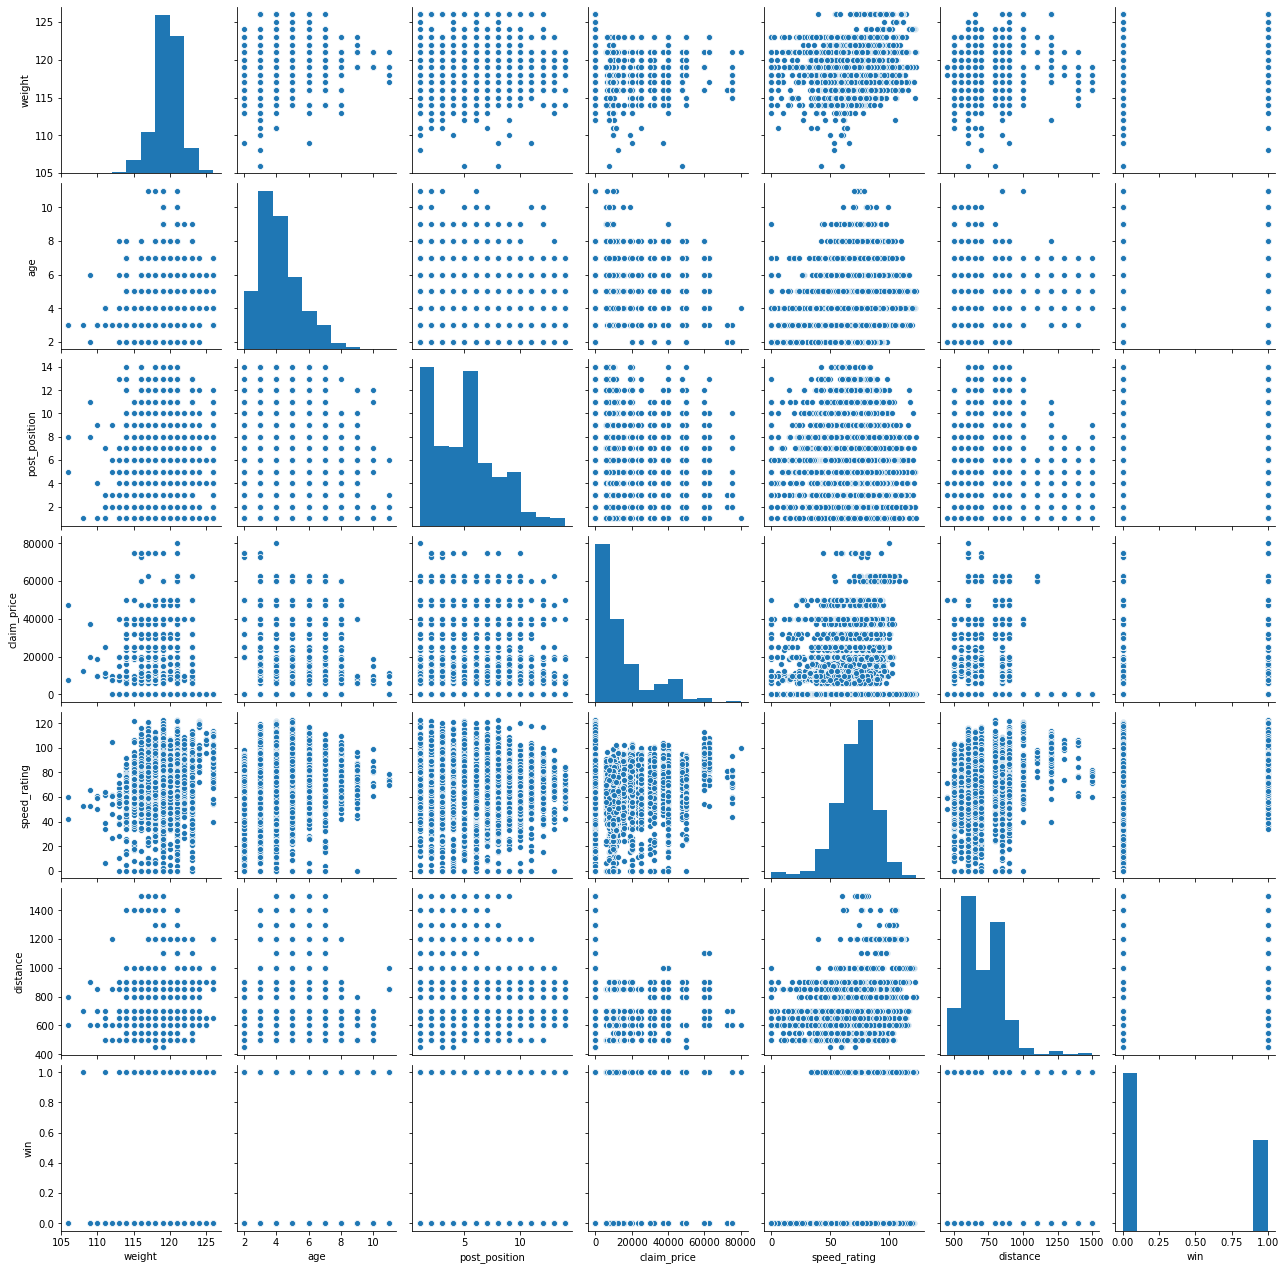

<IPython.core.display.Javascript object>

In [35]:
plot_cols = num_cols.copy()
plot_cols.append("win")
sns.pairplot(df[plot_cols])
plt.show()

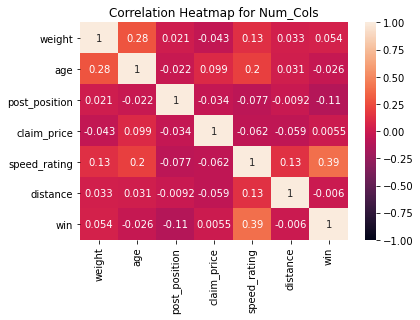

<IPython.core.display.Javascript object>

In [36]:
sns.heatmap(df[plot_cols].corr(), vmin=-1, annot=True)
plt.title("Correlation Heatmap for Num_Cols")
plt.show()

In [37]:
df["win"].mean()

0.36426482318532305

<IPython.core.display.Javascript object>

# Modeling

In [38]:
X = df.drop(["win", "jockey", "trainer", "owner"], axis=1)
y = df["win"]

<IPython.core.display.Javascript object>

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

<IPython.core.display.Javascript object>

In [40]:
# fmt: off
preprocessing = ColumnTransformer([
    # Encode categories
    # Potentially use one of the 2 below options
    ("OneHotEncoder", OneHotEncoder(drop=drop_cats), cat_cols),
    # Scale numeric columns
    # (not needed for all models but can't hurt)
    ("scaler", StandardScaler(), num_cols)
    # bin_cols we'll leave untouch
], remainder="passthrough")

<IPython.core.display.Javascript object>

In [41]:
pipeline = Pipeline(
    [
        ## Apply ColumnTransformer steps
        ("preprocessing", preprocessing),
        ## Add other steps as desired
        # ('dim_reduction', PCA()),
        ("feature_selection", SelectKBest()),
        ## Choose your model and put it here
        # ("model", LogisticRegression()),
        # ("model", RandomForestClassifier()),
        ("model", GradientBoostingClassifier()),
    ]
)

<IPython.core.display.Javascript object>

In [42]:
grid = {
    # Use model__ with hyperprammeter names after
    # "model__n_estimators": [100, 150],
    ## Select K Best
    "feature_selection__k": [2, 3, 4],
    ## Logistic Regression Hyperparameters
    # "model__C": [0.05, 0.1, 0.5],
    ## Random Forest Classifier Hyperparameters
    "model__n_estimators": [25, 30, 40],
    "model__max_depth": [3, 4, 5],
    "model__min_samples_leaf": [8, 9, 10],
    ## Gradiant Boosting Classifier Hyperparameters
    "model__learning_rate": [0.01, 0.05, 0.1, 0.5]
    # Add other hyperparameters to tune as desired
    # 'dim_reduction__n_components': [2, 3, 4]
}
# fmt: on

<IPython.core.display.Javascript object>

In [43]:
pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, n_jobs=-1, cv=4)
pipeline_cv.fit(X_train, y_train)

print(f"Train score: {pipeline_cv.score(X_train, y_train):.4f}")
print(f"Test score: {pipeline_cv.score(X_test, y_test):.4f}")

Fitting 4 folds for each of 324 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  1.2min finished


Train score: 0.7098
Test score: 0.7030


<IPython.core.display.Javascript object>

Best Results for Logistic Regression Classifier:
> Train score: 0.7115
Test score: 0.7056

Best Results for Random Forest Classifier:
> Train score: 0.7131
Test score: 0.7070

Best Results for Gradiant Boosting Classifier:
> Train score: 0.7098
Test score: 0.7030

In [44]:
pipeline_cv.best_params_

{'feature_selection__k': 3,
 'model__learning_rate': 0.05,
 'model__max_depth': 3,
 'model__min_samples_leaf': 8,
 'model__n_estimators': 40}

<IPython.core.display.Javascript object>

Best Hyperparameters for Logistic Regression Classifier:
> {'feature_selection__k': 7, 'model__C': 0.1}

Best Hyperparameters for Random Forest Classifier:
> {'feature_selection__k': 4,
 'model__max_depth': 5,
 'model__min_samples_leaf': 10,
 'model__n_estimators': 15}

Best Hyperparameters for Gradiant Boosting Classifier:
> {'feature_selection__k': 3,
 'model__learning_rate': 0.05,
 'model__max_depth': 4,
 'model__min_samples_leaf': 9,
 'model__n_estimators': 30}

# Evaluate perfomance

In [45]:
def plot_confusion_matrix(
    cm, classes, normalize, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            verticalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

In [46]:
y_test.value_counts()

0    966
1    539
Name: win, dtype: int64

<IPython.core.display.Javascript object>

In [47]:
# Make predictions
y_pred = pipeline_cv.predict(X_test)
y_pred.sum()

376

<IPython.core.display.Javascript object>

Confusion matrix, without normalization


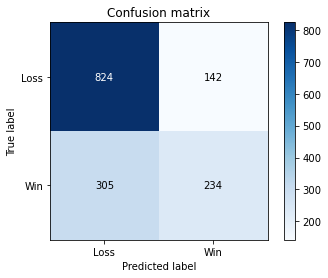

<IPython.core.display.Javascript object>

In [48]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ["Loss", "Win"], False)

Normalized confusion matrix


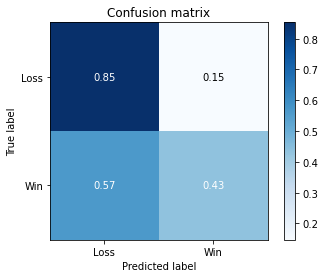

<IPython.core.display.Javascript object>

In [49]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ["Loss", "Win"], True)

In [50]:
report = classification_report(y_test, y_pred, target_names=["Loss", "Win"])
print(report)

              precision    recall  f1-score   support

        Loss       0.73      0.85      0.79       966
         Win       0.62      0.43      0.51       539

    accuracy                           0.70      1505
   macro avg       0.68      0.64      0.65      1505
weighted avg       0.69      0.70      0.69      1505



<IPython.core.display.Javascript object>

# Summary and Recommendations

The three classification models tested each produce very similar score results. Guessing the most likely result for a horse, loss, you would be correct 64% of the time. However, the supervised learning models were able to produce a score of about 71%, which is better than a random guess. The best model tested was the Random Forest Classifier. 

For furthur exploration, I would recommend adding more data feaures, and include more in-depth EDA and Feature Engineering. I would test the models on never before seen data. I would also recommend building a automation test program to place imaginary bets on current horse races to see how it would preform live, over time. This would be a longer term end goal of this analysis. 

In [51]:
## Ideas
# Box plots / t-test for claim_price (actually, for all num_cols)
# Catagorical vars get sns countplot with wins
# Visualize analysis results (performance) of 2-3 different models (box plots)
# What's the best model to use with many columns logistic regression (or use feature selection from model to reduce colums, ie top 20 features)

<IPython.core.display.Javascript object>